# Airline Passenger Satisfaction

Nicholas Lee, Mohammad Mahmoudighaznavi and Christine Vu

Shiley-Marcos School of Engineering, University of San Diego

ADS 505: Applied Data Science for Business

Dr. Ebrahim Tarshizi

September 21, 2022

***

## Data Description

-

***

## Data Importing and Pre-processing

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tools.tools as stattools
import warnings
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn import linear_model, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from scipy import stats
from collections import defaultdict
from pandas.api.types import CategoricalDtype
warnings.filterwarnings("ignore")
%matplotlib inline

airline_train = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_train.csv?token=GHSAT0AAAAAABY77FMSTZO2OCABMALPR6NEYZJ4POA")
airline_test = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_test.csv?token=GHSAT0AAAAAABY77FMT36XI4QAT2J2XROGQYZJ4PPA")

airline_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [2]:
# Drop 'Unnamed:0' and 'ID' Columns
airline_train = airline_train.drop(["Unnamed: 0", "id"], axis = 1)
airline_test = airline_test.drop(["Unnamed: 0", "id"], axis = 1)

In [3]:
# Concat training and testing dataframes
df = [airline_train, airline_test]
combine_df = pd.concat(df)

# Split the data in 70/30 for train/valid datasets
trainData, validData = train_test_split(combine_df, test_size = 0.3, random_state = 1)

print("- Training:", trainData.shape)
print("- Validation:", validData.shape)

- Training: (90916, 23)
- Validation: (38964, 23)


In [4]:
# Key statistics of studied variables
airline_train.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [5]:
# Data types of all columns
airline_train.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

In [6]:
# Shape of the data (Instances and attributes)
print("Number of instances: %d" % (airline_train.shape[0]))
print("Number of attributes: %d" % (airline_train.shape[1]))

Number of instances: 103904
Number of attributes: 23


In [7]:
# Find missing values
airline_train.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [8]:
# Impute missing 'Arrival Delay in Minutes' values
imputer = SimpleImputer(strategy = 'constant', missing_values = np.nan, fill_value = 0)
imputer = imputer.fit(airline_train[['Arrival Delay in Minutes']])
airline_train[['Arrival Delay in Minutes']] = imputer.transform(airline_train[['Arrival Delay in Minutes']])

# Confirm there are no more missing 'Arrival Delay in Minutes' values
airline_train['Arrival Delay in Minutes'].isnull().sum()

0

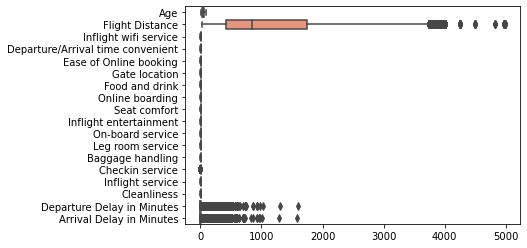

In [9]:
# Boxplot of all attributes to observe outliers
bp = sns.boxplot(data = airline_train, orient = "h")

In [10]:
# Determine if 'satisfaction' column is balanced
# Data is balanced, so rebalancing is unnecessary
airline_train['satisfaction'].value_counts()

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64

In [23]:
# Bin 'Age' column categories:
# Ages 0 to 3: Toddler
# Ages 4 to 17: Child
# Ages 18 to 25: Young Adult
# Ages 26 to 64: Adult
# Ages 65 to 99: Elder

binned_ages = airline_train.copy()
binned_ages['Age'] = pd.cut(binned_ages['Age'], bins = [0, 3, 17, 25, 64, 99],
                            labels = ['Toddler', 'Child', 'Young Adult', 'Adult', 'Elder'])

binned_ages.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,Child,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,Young Adult,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,Adult,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,Young Adult,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,Adult,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


***

## Exploratory Data Analysis: Univariate Analysis
1. One categorical variable
2. One continuous variable

### One categorical variable
1. Bar plot: Class

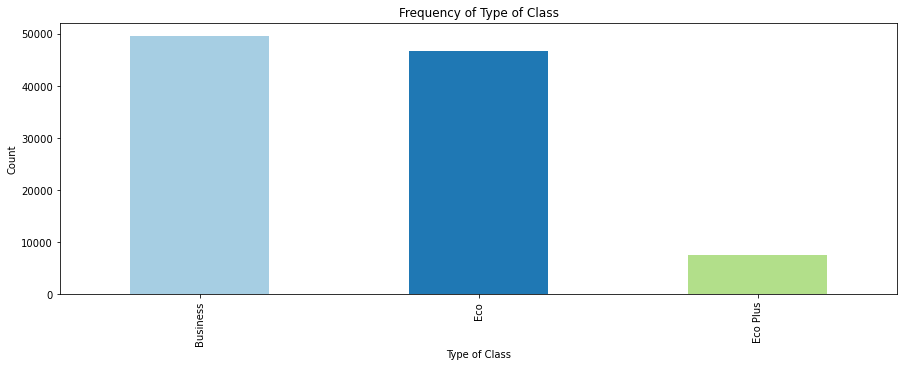

In [12]:
# 1. Bar plot: Class
class_type = airline_train.groupby('Class').agg({'Class': 'count'})
class_type = class_type['Class'].sort_values(ascending = False)

class_type.plot(kind = 'bar', figsize = (15, 5), color = plt.cm.Paired(np.arange(len(airline_train))))
plt.title("Frequency of Type of Class")
plt.xlabel("Type of Class")
plt.ylabel("Count")
plt.show()

### One continuous variable
1. Histogram: Ease of Online booking

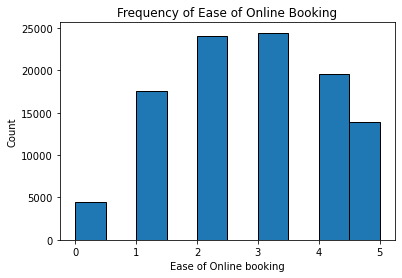

In [13]:
# 1. Histogram: Ease of Online booking
plt.hist(airline_train['Ease of Online booking'], bins = 10, edgecolor = 'black')
plt.title("Frequency of Ease of Online Booking")
plt.xlabel("Ease of Online booking")
plt.ylabel("Count")
plt.show()

## Exploratory Data Analysis: Multivariate Analysis
1. Relationship between two categorical variables
2. Relationship between two continuous variables
3. Relationship between one categorical and one continuous variable
4. Relationship between all continuous variables

### Two categorical variables
1. Bar plot: Customer Type and Satisfaction
2. Bar plot: Class and Satisfaction

In [14]:
# 1. Customer Type and Satisfaction
crosstab01 = pd.crosstab(airline_train['Customer Type'], airline_train['satisfaction'])
crosstab01 = crosstab01.sort_values('neutral or dissatisfied', ascending = False)
crosstab01

satisfaction,neutral or dissatisfied,satisfied
Customer Type,,
Loyal Customer,44390,40533
disloyal Customer,14489,4492


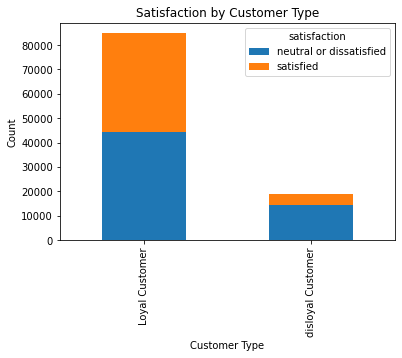

In [15]:
crosstab01.plot(kind = 'bar', stacked = True)
plt.title("Satisfaction by Customer Type")
plt.ylabel("Count")
plt.show()

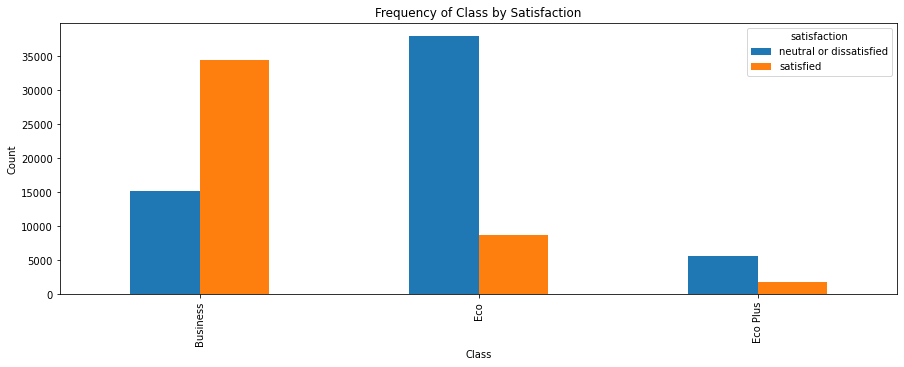

In [17]:
# 2. Bar plot: Class and Satisfaction
class_count = airline_train['Class'].value_counts().index
ordered_class = CategoricalDtype(categories = class_count)
airline_train['Class'] = airline_train['Class'].astype(ordered_class)
pd.crosstab(airline_train['Class'], airline_train['satisfaction']).plot(kind = "bar", figsize = (15, 5))

plt.title("Frequency of Class by Satisfaction")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Two continuous variables
1. Scatterplot: Scatterplot of Age and Inflight entertainment
2. Scatterplot: Age and Flight Distance
3. Box plot: Class and Baggage handling, considering Gender

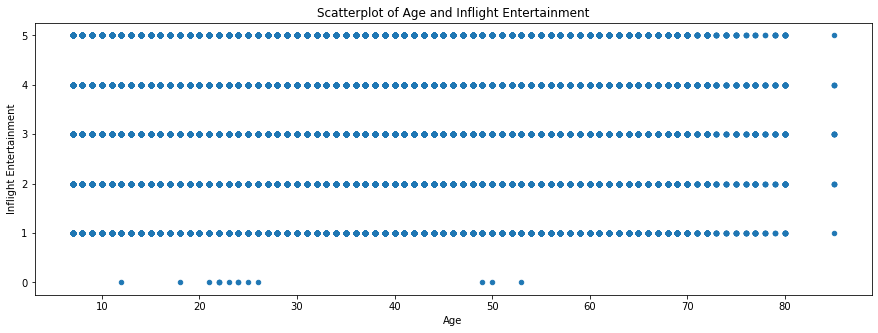

In [18]:
# 1. Scatterplot: Age and Inflight entertainment
airline_train.plot.scatter(x = 'Age', y = 'Inflight entertainment', marker = 'o', figsize = (15,5))

plt.title("Scatterplot of Age and Inflight Entertainment")
plt.xlabel("Age")
plt.ylabel("Inflight Entertainment")
plt.show()

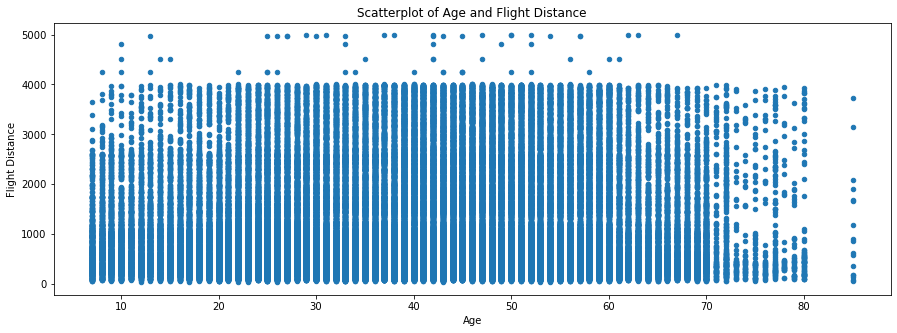

In [19]:
# 2. Scatterplot: Age and Flight Distance
airline_train.plot.scatter(x = 'Age', y = 'Flight Distance', marker = 'o', figsize = (15,5))

plt.title("Scatterplot of Age and Flight Distance")
plt.xlabel("Age")
plt.ylabel("Flight Distance")
plt.show()

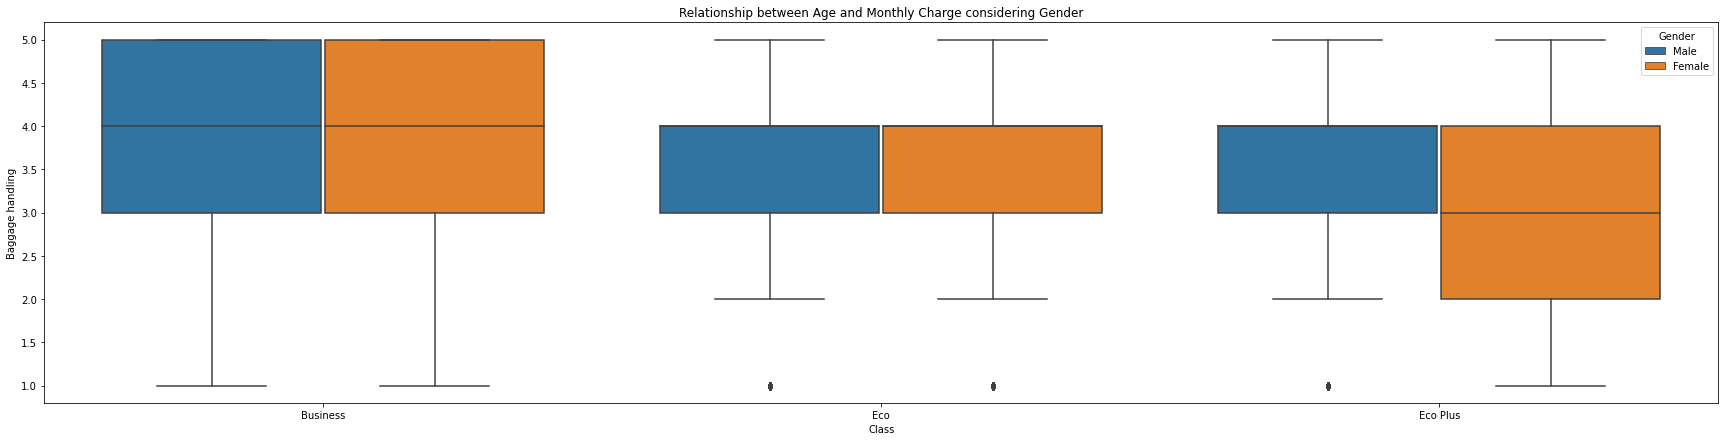

In [20]:
#3. Box plot: Class and Baggage handling, considering Gender
plt.figure(figsize = (30, 7))

sns.boxplot(x = "Class", y = "Baggage handling", hue = "Gender", data = airline_train)
plt.title("Relationship between Age and Monthly Charge considering Gender")
plt.show()

### One categorical and one continuous variable
1. Box plot: Inflight wifi service and satisfaction

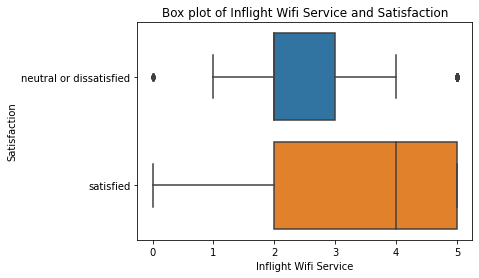

In [21]:
# 1. Box plot: Inflight wifi service and satisfaction
sns.boxplot(x = "Inflight wifi service", y = "satisfaction", data = airline_train)

plt.title("Box plot of Inflight Wifi Service and Satisfaction")
plt.xlabel("Inflight Wifi Service")
plt.ylabel("Satisfaction")
plt.show()

### All continuous variables
1. Heat map: All continuous variables

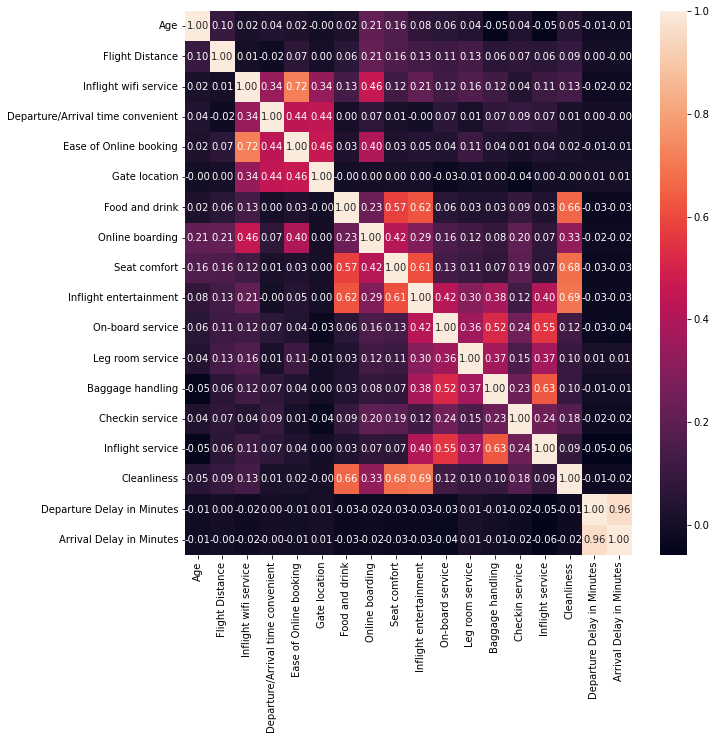

In [27]:
# 1. Heat map: All continuous variables
plt.figure(figsize=(10, 10))
sns.heatmap(airline_train.corr(), annot = True, fmt = '.2f')
plt.show()

***

## Binary Classification Model
1. Feature Selection
2. K-Fold Cross Validation and Prediction Modeling
3. Decision Tree
4. Naïve Bayes
5. Random Forest
6. K-means clustering
7. C5.0
8. CART